<a href="https://colab.research.google.com/github/agrezende/dask-tutorial/blob/develop/01_dask.delayed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">

# Parallelize code with `dask.delayed`

In this section we parallelize simple for-loop style code with Dask and `dask.delayed`. Often, this is the only function that you will need to convert functions for use with Dask.

This is a simple way to use `dask` to parallelize existing codebases or build [complex systems](https://blog.dask.org/2018/02/09/credit-models-with-dask).  This will also help us to develop an understanding for later sections.

**Related Documentation**

* [Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
* [Delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU)
* [Delayed API](https://docs.dask.org/en/latest/delayed-api.html)
* [Delayed examples](https://examples.dask.org/delayed.html)
* [Delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html)

As we'll see in the [distributed scheduler notebook](05_distributed.ipynb), Dask has several ways of executing code in parallel. We'll use the distributed scheduler by creating a `dask.distributed.Client`. For now, this will provide us with some nice diagnostics. We'll talk about schedulers in depth later.

In [1]:
# !pip install dask==1.0.0 distributed'>=1.21.6,<2.0.0'
!pip install dask==1.0.0 distributed==1.28.1

     |████████████████████████████████| 686kB 6.6MB/s 
     |████████████████████████████████| 522kB 9.6MB/s 
  Found existing installation: dask 2.12.0
    Uninstalling dask-2.12.0:
      Successfully uninstalled dask-2.12.0
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3


In [11]:
!pip install dask distributed --upgrade


Requirement already up-to-date: dask in /usr/local/lib/python3.7/dist-packages (2021.3.0)
     |████████████████████████████████| 675kB 5.7MB/s 
  Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Found existing installation: distributed 1.28.1
    Uninstalling distributed-1.28.1:
      Successfully uninstalled distributed-1.28.1


In [1]:
from dask.distributed import Client

client = Client(n_workers=4)

In [2]:
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4, n_workers=1, memory_limit='2GB', scheduler_port=8780)
# client = Client(processes=False, n_workers=4, scheduler_port=8780)

In [2]:
client

Client Scheduler: tcp://127.0.0.1:45787 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 13.65 GB


## Basics

First let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally.

In the next section we'll parallelize this code.

In [5]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

We time the execution of this normal code using the `%%time` magic, which is a special function of the Jupyter Notebook.

In [5]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 179 ms, sys: 28.6 ms, total: 208 ms
Wall time: 3 s


### Parallelize with the `dask.delayed` decorator

Those two increment calls *could* be called in parallel, because they are totally independent of one-another.

We'll transform the `inc` and `add` functions using the `dask.delayed` function. When we call the delayed version by passing the arguments, exactly as before, the original function isn't actually called yet - which is why the cell execution finishes very quickly.
Instead, a *delayed object* is made, which keeps track of the function to call and the arguments to pass to it.


In [3]:
from dask import delayed

In [6]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 1.97 ms, sys: 0 ns, total: 1.97 ms
Wall time: 7.03 ms


This ran immediately, since nothing has really happened yet.

To get the result, call `compute`. Notice that this runs faster than the original code.

In [9]:
from dask.diagnostics import ProgressBar

# pbar = ProgressBar()
# pbar.register()

# pbar.

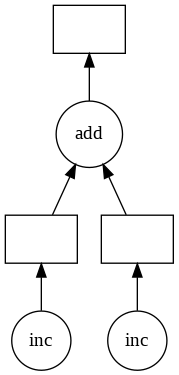

In [7]:
z.visualize()

In [8]:
# %%time
# This actually runs our computation using a local thread pool

z.compute()

5

In [ ]:
%%time
# This actually runs our computation using a local thread pool

with ProgressBar():
  z.compute()

## What just happened?

The `z` object is a lazy `Delayed` object.  This object holds everything we need to compute the final result, including references to all of the functions that are required and their inputs and relationship to one-another.  We can evaluate the result with `.compute()` as above or we can visualize the task graph for this value with `.visualize()`.

In [9]:
z

Delayed('add-220d415b-59cc-45a5-87c4-940097b9eaf0')

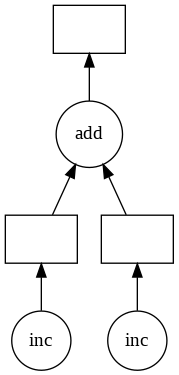

In [8]:
# Look at the task graph for `z`
z.visualize()

Notice that this includes the names of the functions from before, and the logical flow of the outputs of the `inc` functions to the inputs of `add`.

### Some questions to consider:

-  Why did we go from 3s to 2s?  Why weren't we able to parallelize down to 1s?
-  What would have happened if the inc and add functions didn't include the `sleep(1)`?  Would Dask still be able to speed up this code?
-  What if we have multiple outputs or also want to get access to x or y?

## Exercise: Parallelize a for loop

`for` loops are one of the most common things that we want to parallelize.  Use `dask.delayed` on `inc` and `sum` to parallelize the computation below:

In [10]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [11]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 398 ms, sys: 68.6 ms, total: 467 ms
Wall time: 8.01 s


In [12]:
total

44

In [18]:
%%time
# Your parallel code here...
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)


CPU times: user 3.01 ms, sys: 0 ns, total: 3.01 ms
Wall time: 3.06 ms


In [19]:
%%time
total.compute()

CPU times: user 130 ms, sys: 19.5 ms, total: 149 ms
Wall time: 2.05 s


44

In [13]:
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
# result = total.compute()
# print("After computing :", result)  # After it's computed

Before computing: Delayed('sum-f036f7b7-f1f2-4574-8643-249a9f0f0547')


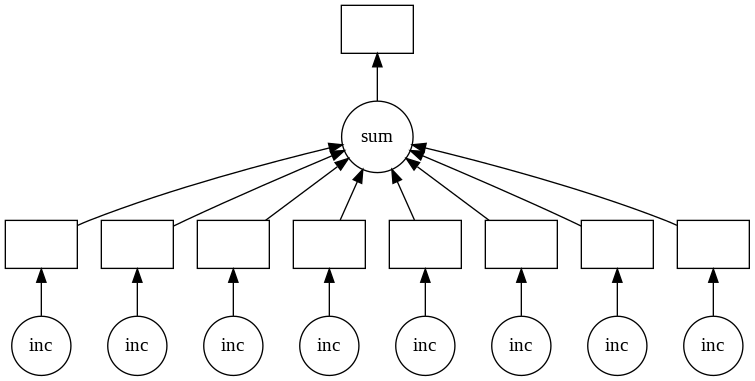

In [15]:
total.visualize()

In [16]:
from dask.diagnostics import ProgressBar

with ProgressBar():
  result = total.compute()

In [17]:
result = total.compute()
print("After computing :", result)  # After it's computed

After computing : 44


How do the graph visualizations compare with the given solution, compared to a version with the `sum` function used directly rather than wrapped with `delayed`? Can you explain the latter version? You might find the result of the following expression illuminating
```python
delayed(inc)(1) + delayed(inc)(2)
```

## Exercise: Parallelizing a for-loop code with control flow

Often we want to delay only *some* functions, running a few of them immediately.  This is especially helpful when those functions are fast and help us to determine what other slower functions we should call.  This decision, to delay or not to delay, is usually where we need to be thoughtful when using `dask.delayed`.

In the example below we iterate through a list of inputs.  If that input is even then we want to call `inc`.  If the input is odd then we want to call `double`.  This `is_even` decision to call `inc` or `double` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [20]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [21]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

90
CPU times: user 572 ms, sys: 68.8 ms, total: 641 ms
Wall time: 10 s


In [22]:
%%time
# Your parallel code here...
# TODO: parallelize the sequential code above using dask.delayed
# You will need to delay some functions, but not all

results = []
for x in data:
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print(total)

Delayed('sum-00857997-95f1-4fc5-9664-c9d671a54551')
CPU times: user 3.48 ms, sys: 79 µs, total: 3.56 ms
Wall time: 3.04 ms


In [23]:
%%time
total.compute()

CPU times: user 187 ms, sys: 30.6 ms, total: 218 ms
Wall time: 3.06 s


90

In [24]:
results = []
for x in data:
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

In [25]:
%time total.compute()

CPU times: user 180 ms, sys: 25.3 ms, total: 206 ms
Wall time: 3.05 s


90

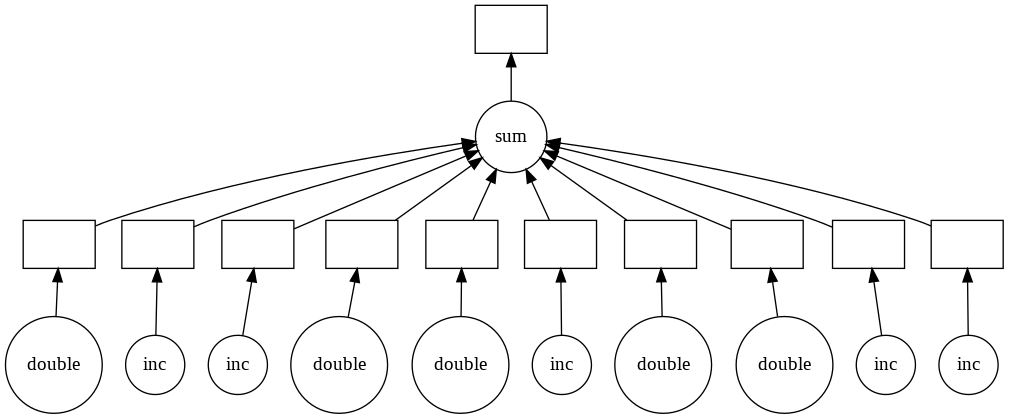

In [26]:
total.visualize()

### Some questions to consider:

-  What are other examples of control flow where we can't use delayed?
-  What would have happened if we had delayed the evaluation of `is_even(x)` in the example above?
-  What are your thoughts on delaying `sum`?  This function is both computational but also fast to run.

## Exercise: Parallelizing a Pandas Groupby Reduction

In this exercise we read several CSV files and perform a groupby operation in parallel.  We are given sequential code to do this and parallelize it with `dask.delayed`.

The computation we will parallelize is to compute the mean departure delay per airport from some historical flight data.  We will do this by using `dask.delayed` together with `pandas`.  In a future section we will do this same exercise with `dask.dataframe`.

## Create data

Run this code to prep some data.

This downloads and extracts some historical flight data for flights out of NYC between 1990 and 2000. The data is originally from [here](http://stat-computing.org/dataexpo/2009/the-data.html).

In [29]:
!git clone https://github.com/agrezende/dask-tutorial.git

Cloning into 'dask-tutorial'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 2670 (delta 125), reused 161 (delta 105), pack-reused 2452
Receiving objects: 100% (2670/2670), 83.33 MiB | 26.47 MiB/s, done.
Resolving deltas: 100% (1715/1715), done.


In [32]:
import os
!pwd
os.chdir('/content/dask-tutorial')
!pwd

/content
/content/dask-tutorial


In [33]:
%run prep.py -d flights

- Downloading NYC Flights dataset... done
- Extracting flight data... done
- Creating json data... done
** Created flights dataset! in 3.83s**


### Inspect data

In [35]:
import os
sorted(os.listdir(os.path.join('data', 'nycflights')))

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

### Read one file with `pandas.read_csv` and compute mean departure delay

In [36]:
import pandas as pd
df = pd.read_csv(os.path.join('data', 'nycflights', '1990.csv'))
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,81,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,81,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,81,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,81,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,81,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [37]:
# What is the schema?
df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum              float64
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
Diverted               int64
dtype: object

In [38]:
# What originating airports are in the data?
df.Origin.unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

In [39]:
# Mean departure delay per-airport for one year
df.groupby('Origin').DepDelay.mean()

Origin
EWR     9.168411
JFK    11.857274
LGA     8.560045
Name: DepDelay, dtype: float64

### Sequential code: Mean Departure Delay Per Airport

The above cell computes the mean departure delay per-airport for one year. Here we expand that to all years using a sequential for loop.

In [40]:
from glob import glob
filenames = sorted(glob(os.path.join('data', 'nycflights', '*.csv')))

In [49]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    print("Lendo {}".format(fn))
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

Lendo data/nycflights/1990.csv
Lendo data/nycflights/1991.csv
Lendo data/nycflights/1992.csv
Lendo data/nycflights/1993.csv
Lendo data/nycflights/1994.csv
Lendo data/nycflights/1995.csv
Lendo data/nycflights/1996.csv
Lendo data/nycflights/1997.csv
Lendo data/nycflights/1998.csv
Lendo data/nycflights/1999.csv
CPU times: user 4.53 s, sys: 119 ms, total: 4.65 s
Wall time: 4.43 s


In [50]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### Parallelize the code above

Use `dask.delayed` to parallelize the code above.  Some extra things you will need to know.

1.  Methods and attribute access on delayed objects work automatically, so if you have a delayed object you can perform normal arithmetic, slicing, and method calls on it and it will produce the correct delayed calls.

    ```python
    x = delayed(np.arange)(10)
    y = (x + 1)[::2].sum()  # everything here was delayed
    ```
2.  Calling the `.compute()` method works well when you have a single output.  When you have multiple outputs you might want to use the `dask.compute` function:

    ```python
    >>> from dask import compute
    >>> x = delayed(np.arange)(10)
    >>> y = x ** 2
    >>> min_, max_ = compute(y.min(), y.max())
    >>> min_, max_
    (0, 81)
    ```
    
    This way Dask can share the intermediate values (like `y = x**2`)
    
So your goal is to parallelize the code above (which has been copied below) using `dask.delayed`.  You may also want to visualize a bit of the computation to see if you're doing it correctly.

In [44]:
from dask import compute

In [129]:
%%time

# copied sequential code

sums = []
counts = []
for fn in filenames:
    # Read in file
    # print("Lendo {}".format(fn))
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights
print(mean)

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64
CPU times: user 4.42 s, sys: 100 ms, total: 4.52 s
Wall time: 4.32 s


In [52]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [47]:
%%time
# your code here

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


If you load the solution, add `%%time` to the top of the cell to measure the running time.

In [109]:
%%time

# This is just one possible solution, there are
# several ways to do this using `delayed`

# !pwd

sums = []
counts = []
for fn in filenames:
    # Read in file
    fn = "/content/dask-tutorial/" + fn
    print("Lendo {}".format(fn))
    # print(type(fn))
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
# sums, counts = compute(sums, counts)
# sums = compute(sums)
# counts = compute(counts)

# Combine intermediates to get total mean-delay-per-origin
# total_delays = sum(sums)
# n_flights = sum(counts)
# mean = total_delays / n_flights

Lendo /content/dask-tutorial/data/nycflights/1990.csv
Lendo /content/dask-tutorial/data/nycflights/1991.csv
Lendo /content/dask-tutorial/data/nycflights/1992.csv
Lendo /content/dask-tutorial/data/nycflights/1993.csv
Lendo /content/dask-tutorial/data/nycflights/1994.csv
Lendo /content/dask-tutorial/data/nycflights/1995.csv
Lendo /content/dask-tutorial/data/nycflights/1996.csv
Lendo /content/dask-tutorial/data/nycflights/1997.csv
Lendo /content/dask-tutorial/data/nycflights/1998.csv
Lendo /content/dask-tutorial/data/nycflights/1999.csv
CPU times: user 13.1 ms, sys: 1.18 ms, total: 14.3 ms
Wall time: 13.2 ms


In [ ]:
display(df.visualize())

In [ ]:
display(total.visualize())

In [ ]:
count.visualize()

In [ ]:
%%time
# Compute the intermediates
sums, counts = compute(sums, counts)
# sums = compute(sums)
# counts = compute(counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

In [110]:
%%time
# Compute the intermediates
# sums, counts = compute(sums, counts)
# sums = compute(sums)
# counts = compute(counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 5.01 ms, sys: 0 ns, total: 5.01 ms
Wall time: 7.03 ms


In [99]:
%%time
# Compute the intermediates
# sums, counts = compute(sums, counts)
# sums = compute(sums)
# counts = compute(counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = delayed(sum)(sums)
n_flights = delayed(sum)(counts)
# mean = total_delays / n_flights

CPU times: user 1.01 ms, sys: 0 ns, total: 1.01 ms
Wall time: 938 µs


In [103]:
mean = total_delays / n_flights

Delayed('truediv-2428939989693c3f948ab88675e3de75')

In [111]:
mean

Delayed('truediv-4b7fa551d73bb797349bd928e9920662')

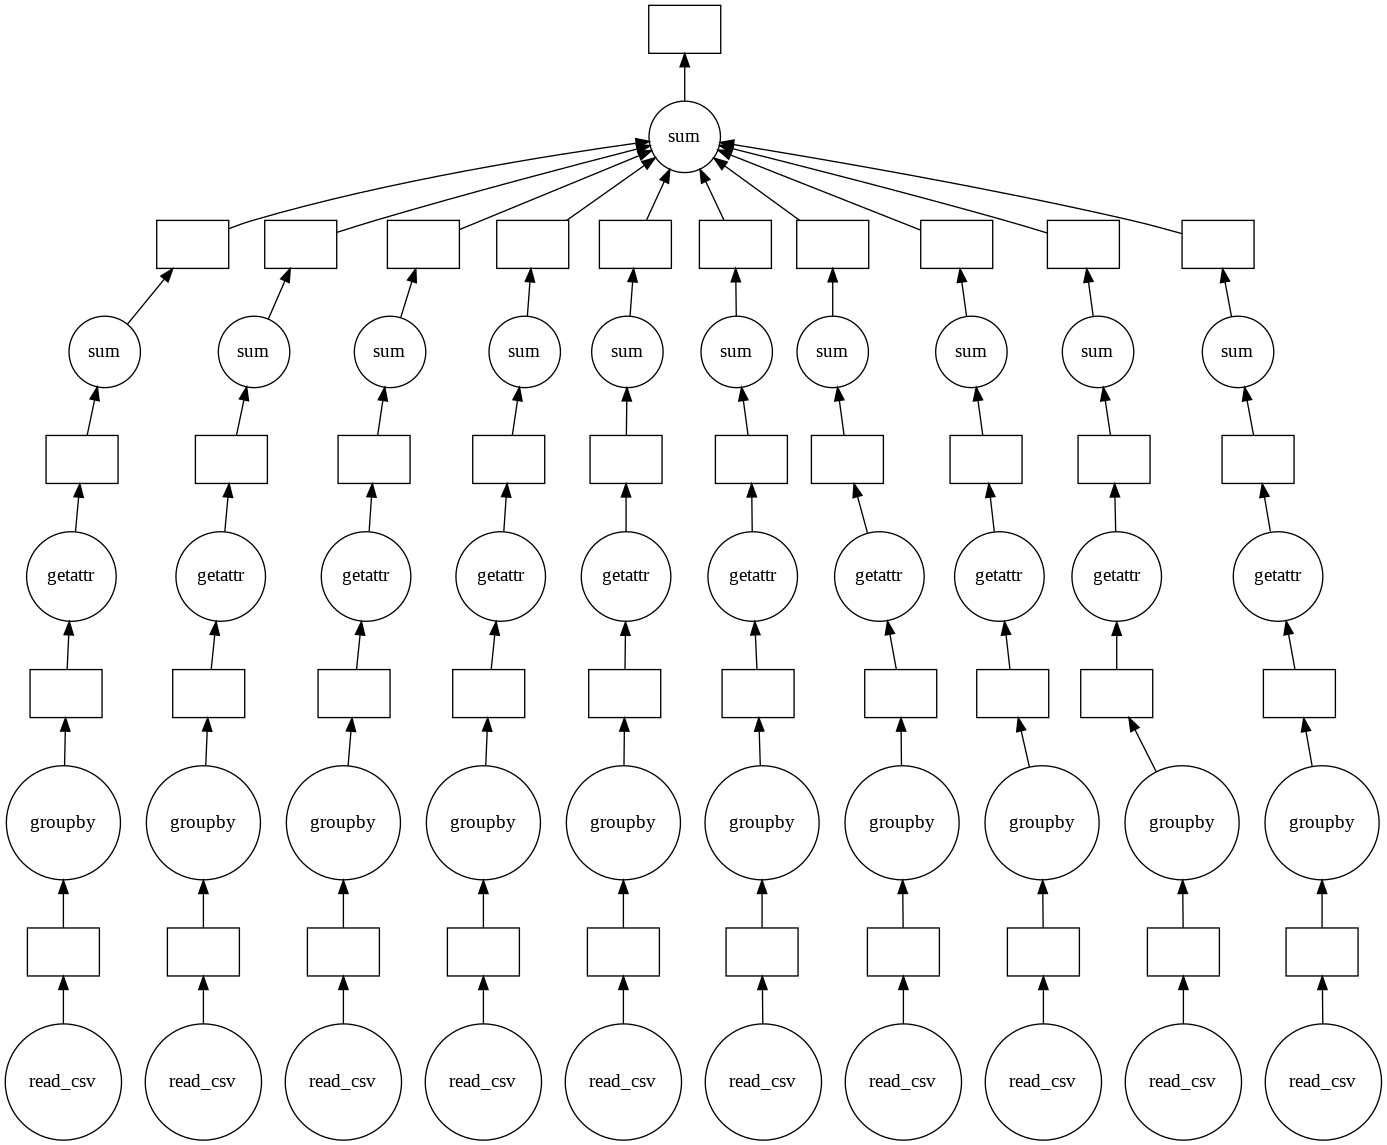

In [100]:
display(total_delays.visualize())

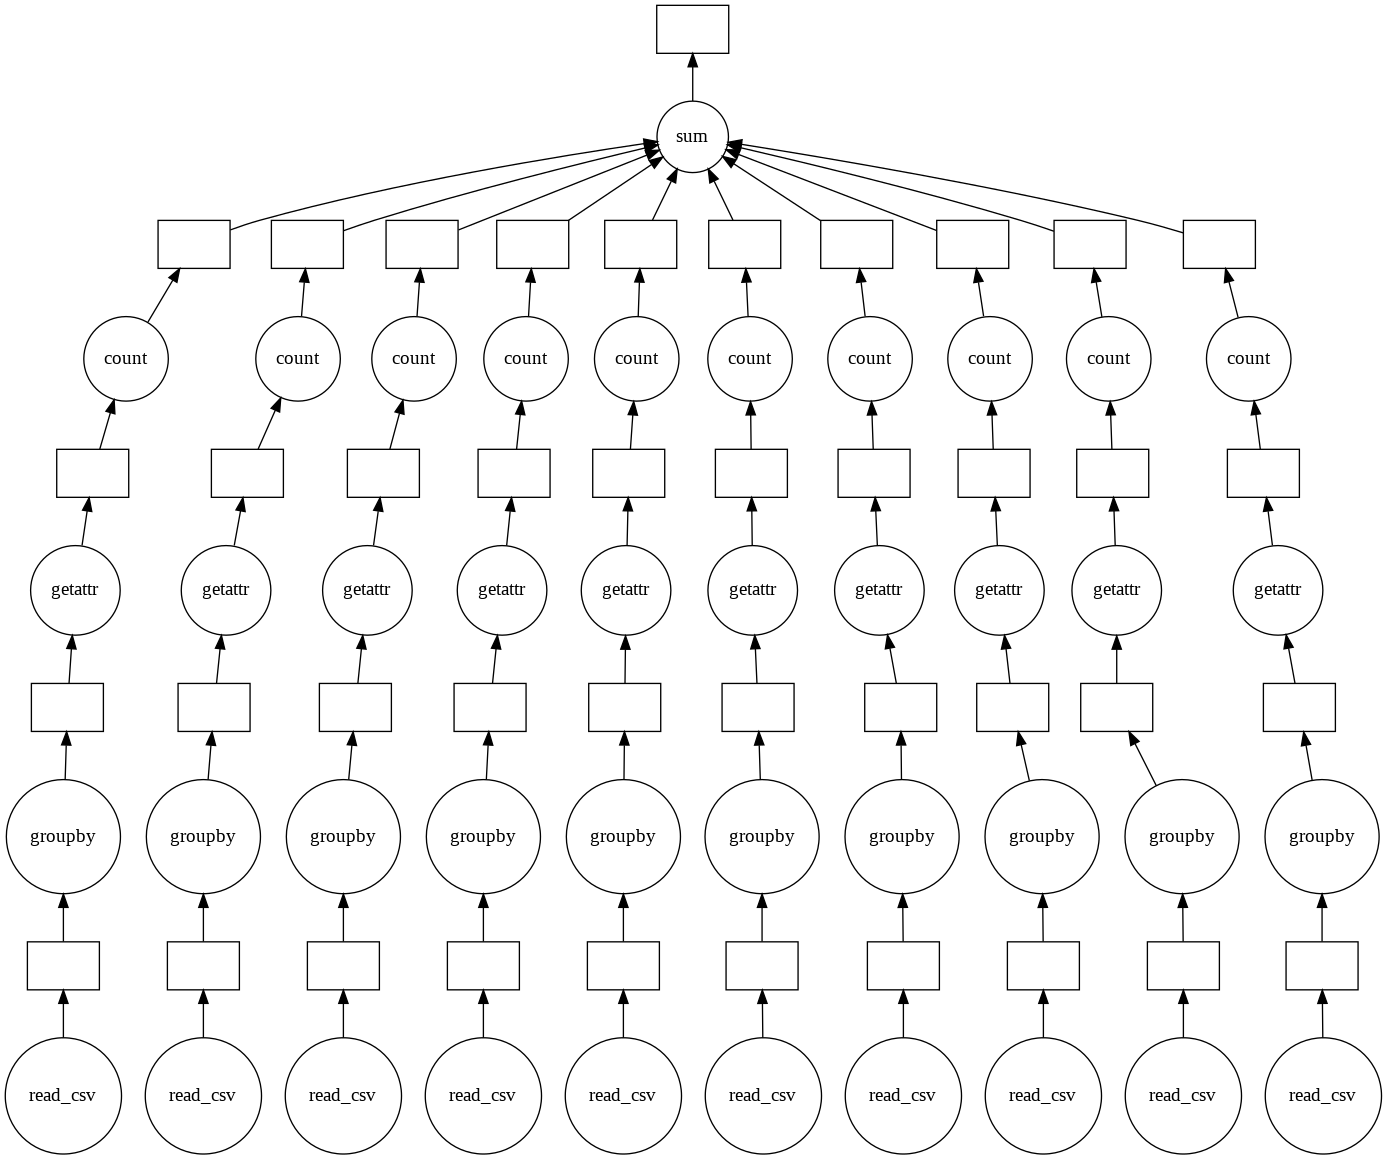

In [101]:
display(n_flights.visualize())

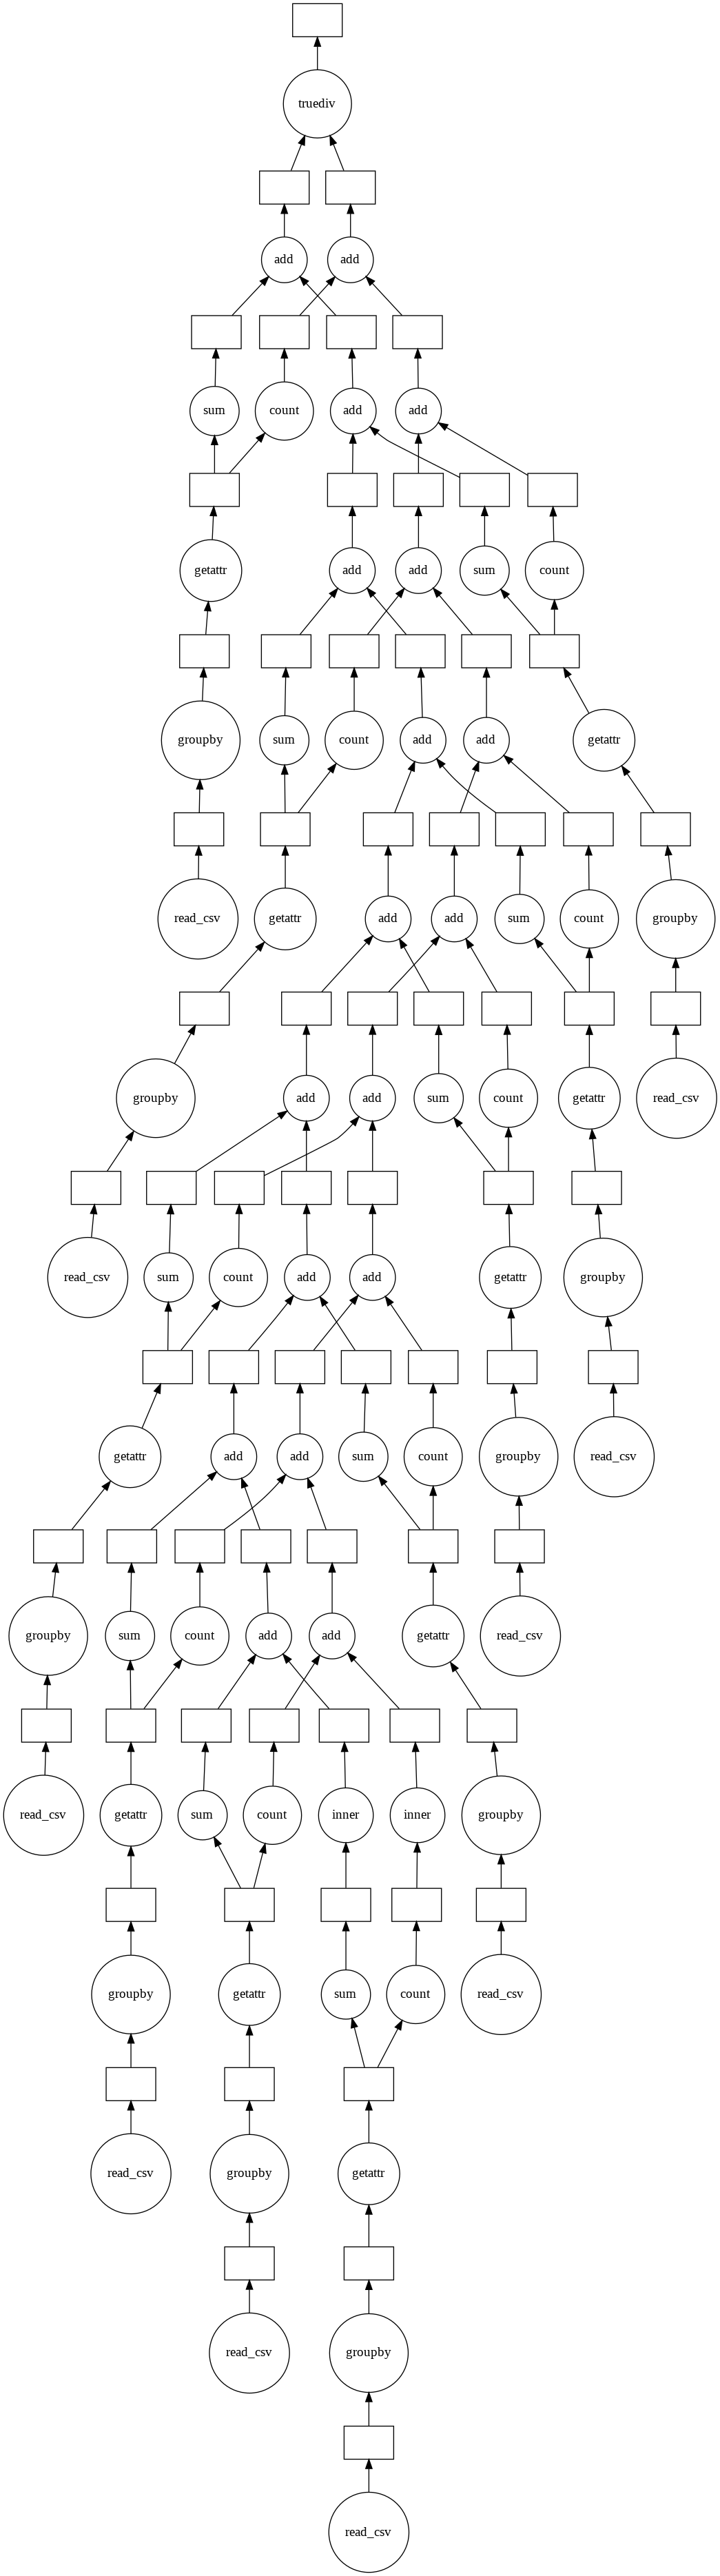

In [112]:
mean.visualize()

In [113]:
%time mean = mean.compute()

CPU times: user 506 ms, sys: 60.6 ms, total: 567 ms
Wall time: 5.23 s


In [108]:
# ensure the results still match
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [128]:
%%time

# This is just one possible solution, there are
# several ways to do this using `delayed`

# !pwd

sums = []
counts = []
for fn in filenames:
    # Read in file
    fn = "/content/dask-tutorial/" + fn
    # print("Lendo {}".format(fn))
    # print(type(fn))
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
# sums, counts = compute(sums, counts)
# sums = compute(sums)
# counts = compute(counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights
print(mean.compute())

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64
CPU times: user 532 ms, sys: 51 ms, total: 583 ms
Wall time: 5.45 s


In [ ]:
mean.visualize()

In [116]:
%%time
mean.compute()

CPU times: user 434 ms, sys: 58.5 ms, total: 493 ms
Wall time: 4.72 s


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [127]:
%%time

# This is just one possible solution, there are
# several ways to do this using `delayed`

# !pwd

sums = []
counts = []
for fn in filenames:
    # Read in file
    fn = "/content/dask-tutorial/" + fn
    # print("Lendo {}".format(fn))
    # print(type(fn))
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
# sums, counts = compute(sums, counts)
# sums = compute(sums)
# counts = compute(counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = delayed(sum)(sums)
n_flights = delayed(sum)(counts)
mean = total_delays / n_flights
print(mean.compute())

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64
CPU times: user 438 ms, sys: 33.7 ms, total: 471 ms
Wall time: 4.86 s


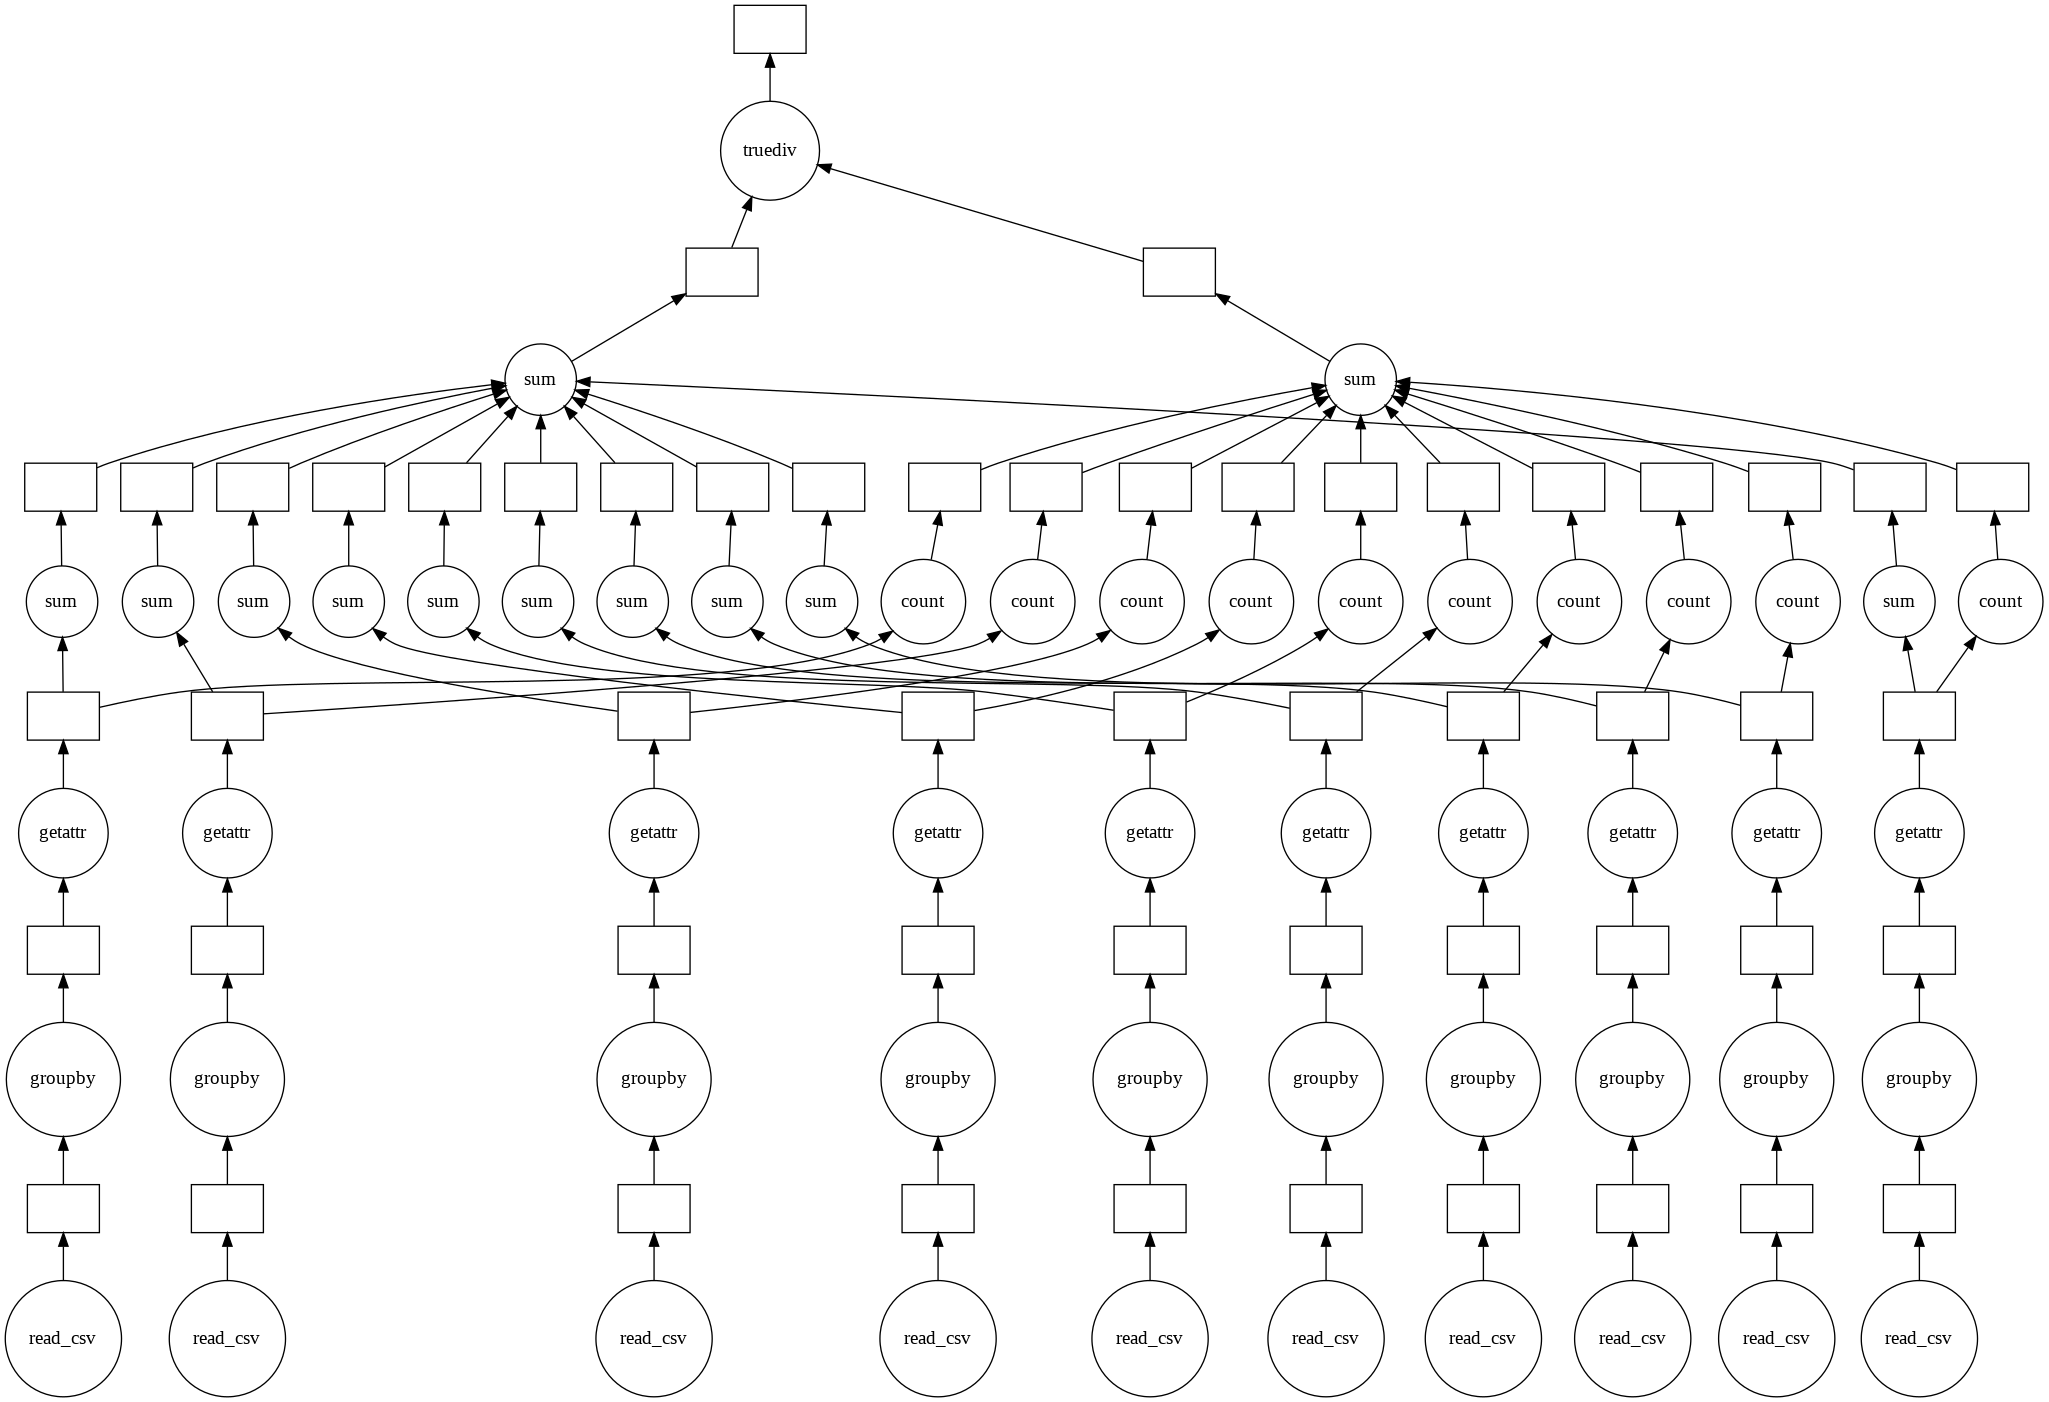

In [118]:
mean.visualize()

In [119]:
%%time
mean.compute()

CPU times: user 433 ms, sys: 42.9 ms, total: 475 ms
Wall time: 4.94 s


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### Some questions to consider:

- How much speedup did you get? Is this how much speedup you'd expect?
- Experiment with where to call `compute`. What happens when you call it on `sums` and `counts`? What happens if you wait and call it on `mean`?
- Experiment with delaying the call to `sum`. What does the graph look like if `sum` is delayed? What does the graph look like if it isn't?
- Can you think of any reason why you'd want to do the reduction one way over the other?

### Learn More

Visit the [Delayed documentation](https://docs.dask.org/en/latest/delayed.html). In particular, this [delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU) will reinforce the concepts you learned here and the [delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html) document collects advice on using `dask.delayed` well.

## Close the Client

Before moving on to the next exercise, make sure to close your client or stop this kernel.

In [132]:
client.close()

In [133]:
client

Client Scheduler: tcp://127.0.0.1:45787 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B
